In [296]:
#imports
import pandas as pd
import re
import pickle
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score

from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import mean_squared_error

## Outline of Analysis
  <p>&nbsp; &nbsp; 1. Web scrape movie labels from [bechdeltest.com](http://bechdeltest.com/)</p>
  <p>&nbsp; &nbsp; 2. Collate dialog lines for each movie [from Cornell study](http://www.cs.cornell.edu/~cristian/papers/chameleons.pdf) and merge with labeled data (407 total movies)</p>
  <p>&nbsp; &nbsp; 3. EDA: score histograms (null model = 59% pass), Heaps Law</p>
  <p>&nbsp; &nbsp; 4. Tokenization->Doc-Term Matrix (a) Count Vectorize, (b)TFIDF)</p>
  <p>&nbsp; &nbsp; 5. Model Assessments, across 5 models and 12 term-doc matrices
  <p>&nbsp; &nbsp; 6. Create new corpus based on badwords, EDA of badword_corpus</p>
  <p>&nbsp; &nbsp; 7. Repeat 4 and 5, but with the badword corpus</p>
  <p>&nbsp; &nbsp; 8. Aggregate Models with GradientBoosting
  <p>&nbsp; &nbsp; 9. Conclusions/future work: >6300 more scripts that can be accessed, topic modeling, word2vec, devise and utilize a [new](http://www.slate.com/blogs/xx_factor/2014/01/07/the_bechdel_test_needs_an_update_we_ve_set_the_bar_for_female_representation.html) and more rigorous metric for assessing female impact in film</p>

# 1. web scraping
See accompanying file, "Obtaining Labels.ipynb"

# 2. Collate dialog lines from Cornell movie-dialog corpus

**Here is a snippet of what the dialog files look like**

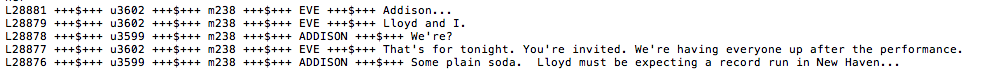

In [12]:
#this is from the "movie_lines.txt" file
#"movie_titles_metadata.txt" is similarly formatted and used to match reference numbers, eg 'm238', with movie titles
Image(filename='./images/dialog example.png')

In [22]:
#get dictionary with entries like 'dark angel': 'm48' (where 'm48' is a type of movie index used in the Cornell dataset)
movie_titles = {}
with open('movie_titles_metadata.txt',encoding='Windows-1252') as f:
    for line in f:
        m = re.search(r'(m[\d]+?) \+\+\+\$\+\+\+ (.+?) \+\+\+\$\+\+\+',line)
        movie_titles[m.group(2)] = m.group(1)

        
#Load labels (scraped with bs4, pickeled in the "Obtaining Labels.ipynb" file)
bechdel_scores = pickle.load( open( "bechdel_test_scores.pickle", "rb" ) )

#lowercase the titles; dict has entries like 'married to the mob': 2 
bechdel_scores = {k.lower():v for k,v in bechdel_scores.items()}

#get intersection of dictionaries
movies_keys = bechdel_scores.keys() & movie_titles.keys()
movies_refnums = {k: movie_titles[k] for k in movies_keys}
movies_bechdel_scores = {k: bechdel_scores[k] for k in movies_keys}

#gather script lines
script_lines_pattern = r'L[\d]+? \+\+\+\$\+\+\+ u[\d]+? \+\+\+\$\+\+\+ (m[\d]+?) \+\+\+\$\+\+\+ .+ \+\+\+\$\+\+\+(.+)'
script_lines = {}

with open('movie_lines.txt',encoding='Windows-1252') as f:
    mov_refnum = 'm0' #initialize with first movie on first line
    count = 0 
    for line in f:
        count+=1
        m_script = re.search(script_lines_pattern,line)
        if m_script==None:
            continue
        if m_script.group(1) in movies_refnums.values(): 
            if m_script.group(1) == mov_refnum:
                if not script_lines:
                    script_lines[mov_refnum] = m_script.group(2).lower()[1:]
                else:
                    script_lines[mov_refnum] = script_lines[mov_refnum]+m_script.group(2).lower()
            else:
                mov_refnum = m_script.group(1)
                script_lines[mov_refnum] = m_script.group(2).lower()[1:]
                
#put the scipt content into a dataframe
data_df = pd.DataFrame([])
scores_ = []
movierefs_ = []
content_ = [] 
for title in movies_bechdel_scores.keys():
    if movies_bechdel_scores[title]<3:
        scores_.append(0)
    else:
        scores_.append(1)
    movierefs_.append(movies_refnums[title])
    content_.append(script_lines[movies_refnums[title]])

data_df['content'] = content_
data_df['movie_ref'] = movierefs_
data_df['score'] = scores_

data_df.iloc[:7,:]

,content,movie_ref,score
0,hey! fuckin' a! just... just like a hot shit.....,m320,1
1,"goodnight, sweetheart. goodnight, malcolm. tel...",m182,1
2,"get the kit! oh my god, oh my god... r.e.m.'s....",m148,0
3,yeah yeah. i'm going to the corner to get a cu...,m217,0
4,sure. she is a dancer! and a lovely one! you w...,m35,0
5,kill you motherfucker!!! i shit on all o' you....,m474,0
6,"as long as i've known andy, he's never asked m...",m258,1


# 3. EDA: score histograms and Heaps Law

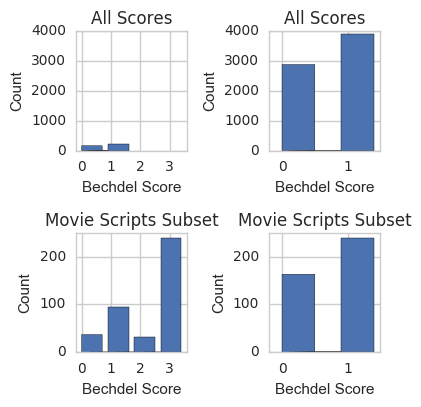

In [31]:
zero_one_scores = []
for title in bechdel_scores.keys():
    if bechdel_scores[title]<3:
        zero_one_scores.append(0)
    else:
        zero_one_scores.append(1)
        
scores_df = pd.DataFrame(scores_,columns=['score'])

fig = plt.figure(figsize=(4,4))
sns.set_style("whitegrid");

ax1 = plt.subplot2grid((2,2),(0,0));
ax1=plt.hist(scores_df.score,width=0.7);
plt.xticks([0,1,2,3]);
plt.yticks([0,1000,2000,3000,4000]);
plt.xlim([-0.2,3.6]);
plt.title('All Scores');
plt.xlabel('Bechdel Score');
plt.ylabel('Count');

ax2 = plt.subplot2grid((2,2),(0,1));
ax2 =plt.hist(zero_one_scores,width=0.5);
plt.xticks([0,1]);
plt.yticks([0,1000,2000,3000,4000]);
plt.xlim([-0.2,1.5])
plt.title('All Scores');
plt.xlabel('Bechdel Score');
plt.ylabel('Count');

ax3 = plt.subplot2grid((2,2),(1,0));
ax3 = plt.hist(list(movies_bechdel_scores.values()),width=0.7);
plt.xticks([0,1,2,3]);
plt.yticks([0,100,200]);
plt.xlim([-0.2,3.6]);
plt.title('Movie Scripts Subset');
plt.xlabel('Bechdel Score');
plt.ylabel('Count');

ax4 = plt.subplot2grid((2,2),(1,1));
ax4 =plt.hist(scores_,width=0.5);
plt.xticks([0,1]);
plt.yticks([0,100,200]);
plt.xlim([-0.2,1.5]);
plt.title('Movie Scripts Subset');
plt.xlabel('Bechdel Score');
plt.ylabel('Count');

plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0);

#(Note: not sure where the bars for 2 and 3 have diappeared to in the upper left plot, 
#as I'm compiling analyses into a single file; but a few cells down I have an image from a
#previous cell run from another file)

In [33]:
#Count passed and not passed for the subset
#of movies I have scripts for
passed = 0
not_passed = 0
weirdness = {}
for key in movies_bechdel_scores.keys():
    movienum = movies_refnums[key]
    if movies_bechdel_scores[key]<3:
        score='no_pass'
        not_passed += 1
    else: 
        score='pass'
        passed += 1

passed/(passed+not_passed)

0.5935162094763092

In [34]:
#Count passed and not passed for
#all movies in the Cornell Corpus
passed = 0
not_passed = 0
for key in bechdel_scores.keys():
    if bechdel_scores[key]<3:
        score='no_pass'
        not_passed += 1
    else: 
        score='pass'
        passed += 1

passed/(passed+not_passed)

0.5749113475177305

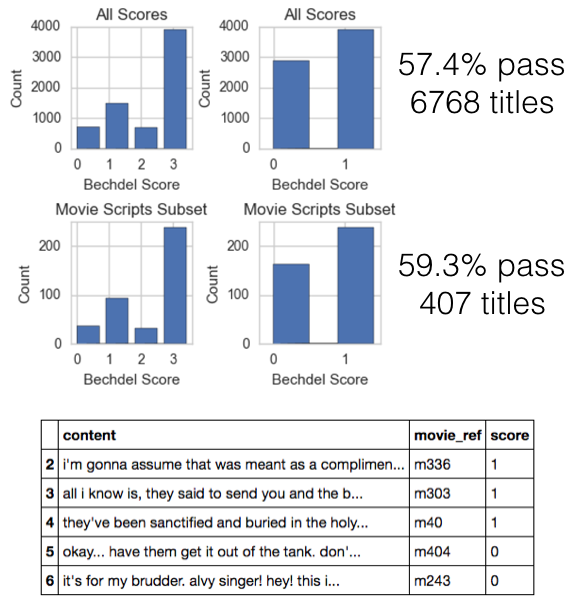

In [54]:
Image(filename='./images/pdf_hists.png')

The visualization of Heaps Law, below, was conducted to see if there might be correlation between unique word usage and Bechdel Test score. The exploratory result suggests that such a correlation is not immediately evident, though this could be explored in more detail in the future.  

In [ ]:
#HEAPS LAW
for i in range(len(data_df.content)):
    blob = TextBlob(data_df.content[i])
    WandP_tokens = blob.tokens
    unique_words = set() 

    heaps_data = []    
    total_words = 0
    for word in WandP_tokens:
        total_words = total_words+1
        unique_words.add(word)
        heaps_data.append((total_words,len(unique_words)))
    tot_words,unique_words = zip(*heaps_data)
    if data_df.score[i]==1: 
        color_ = 'c'
        label_ = 'Passes Bechdel Test'
    else: 
        color_ = 'm'
        label_ = 'Fails Bechdel Test'
    if i<2:
        plt.plot(tot_words,unique_words,color=color_,label=label_);
    else:
        plt.plot(tot_words,unique_words,color=color_);
plt.xlabel('total words');
plt.ylabel('unique words');
plt.legend(loc='upper left');
plt.title('Heaps Law for 401 movies');

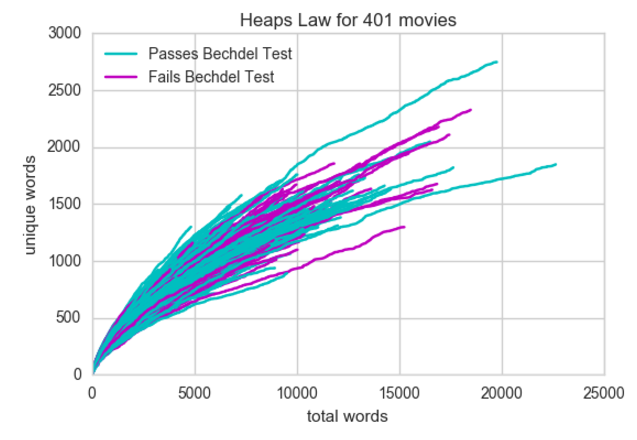

In [17]:
Image(filename='./images/Heaps_Law.png')

# 4. Tokenization->Doc-Term Matrix (a) Count Vectorize, (b)TFIDF)

In [248]:
#TRAIN TEST SPLIT
xTrain, xTest, yTrain, yTest = train_test_split(data_df.content,
                                              data_df.score,
                                              random_state=42,
                                               train_size=0.75)

#GENERATE A VARIETY OF VECTORIZED MATRICES
    
#Make 8 Count_Vectorizers and 4 TFIDF Vectorizers 
Vectorizers = []
Vectorizers.append(CountVectorizer(analyzer='word',ngram_range=(1,1),
                        stop_words='english',max_features=1000))
Vectorizers.append(CountVectorizer(analyzer='word',ngram_range=(1,1),
                        stop_words='english',max_features=None))
Vectorizers.append(CountVectorizer(analyzer='word',ngram_range=(2,2),
                        stop_words='english',max_features=1000))
Vectorizers.append(CountVectorizer(analyzer='word',ngram_range=(2,2),
                        stop_words='english',max_features=None))
Vectorizers.append(CountVectorizer(analyzer='word',ngram_range=(3,3),
                        stop_words='english',max_features=1000))
Vectorizers.append(CountVectorizer(analyzer='word',ngram_range=(3,3),
                        stop_words='english',max_features=None))
Vectorizers.append(CountVectorizer(analyzer='word',ngram_range=(1,5),
                        stop_words='english',max_features=1000))
Vectorizers.append(CountVectorizer(analyzer='word',ngram_range=(1,5),
                        stop_words='english',max_features=None))
Vectorizers.append(TfidfVectorizer(encoding='Windows-1252',analyzer='word',ngram_range=(1,1),stop_words='english'))
Vectorizers.append(TfidfVectorizer(encoding='Windows-1252',analyzer='word',ngram_range=(2,2),stop_words='english'))
Vectorizers.append(TfidfVectorizer(encoding='Windows-1252',analyzer='word',ngram_range=(3,3),stop_words='english'))
Vectorizers.append(TfidfVectorizer(encoding='Windows-1252',analyzer='word',ngram_range=(1,5),stop_words='english'))

#Make a list of 2-element dicts--train,test doc-term matrices--for each vectorizer  
doc_term_matrices = []
for vectorizer in Vectorizers:
    doc_term_dict_ = {}
    doc_term_dict_['train'] = vectorizer.fit_transform(xTrain)
    doc_term_dict_['test'] = vectorizer.transform(xTest)
    doc_term_matrices.append(doc_term_dict_)

In [48]:
for i in range(len(doc_term_matrices)):
    print(doc_term_matrices[i]['train'].shape)
    print(doc_term_matrices[i]['test'].shape)

(300, 1000)
(101, 1000)
(300, 35201)
(101, 35201)
(300, 1000)
(101, 1000)
(300, 448535)
(101, 448535)
(300, 1000)
(101, 1000)
(300, 641204)
(101, 641204)
(300, 1000)
(101, 1000)
(300, 2447220)
(101, 2447220)
(300, 35201)
(101, 35201)
(300, 448535)
(101, 448535)
(300, 641204)
(101, 641204)
(300, 2447220)
(101, 2447220)


# 5. Model Assessments, across 5 models and 12 term-doc matrices

In [ ]:
models_ = [MultinomialNB(),LogisticRegression(),RandomForestClassifier(),AdaBoostClassifier(),LinearSVC()]

sample_source = []
model_name = []
vectorizer_index = []
accuracy = []
precision = []
recall = []
f1 = []
#loop through each model with default params
for model in models_:
    #for each model, loop through each doc-term matrix
    for i in range(len(doc_term_matrices)):
        #get scores from both CV and test samples
        sample_source.append('CV')
        predictions = cross_val_predict(model,doc_term_matrices[i]['train'],yTrain,cv=3)
        model_name.append(str(model))
        vectorizer_index.append(i)
        accuracy.append(accuracy_score(predictions,yTrain))
        precision.append(precision_score(predictions,yTrain))
        recall.append(recall_score(predictions,yTrain))
        f1.append(f1_score(predictions,yTrain))
        
        sample_source.append('test')
        model.fit(doc_term_matrices[i]['train'],yTrain)
        predictions = model.predict(doc_term_matrices[i]['test'])
        model_name.append(str(model))
        vectorizer_index.append(i)
        accuracy.append(accuracy_score(predictions,yTest))
        precision.append(precision_score(predictions,yTest))
        recall.append(recall_score(predictions,yTest))
        f1.append(f1_score(predictions,yTest))

#load results to dataframe for viewing and plotting
Model_Assessments = pd.DataFrame([])
Model_Assessments['sample_source'] = sample_source
Model_Assessments['model_name'] = model_name
Model_Assessments['vectorizer_index'] = vectorizer_index
Model_Assessments['accuracy'] = accuracy
Model_Assessments['precision'] = precision
Model_Assessments['recall'] = recall
Model_Assessments['f1'] = f1

In [ ]:
#edit model names (for display)
new_model_name = []
for model_name in Model_Assessments.model_name:
    if 'MultinomialNB' in model_name: new_model_name.append('NaiveBayes')
    elif 'RandomForest' in model_name: new_model_name.append('RandomForest')
    elif 'LogisticRegression' in model_name: new_model_name.append('LogReg')
    elif 'AdaBoost' in model_name: new_model_name.append('AdaBoost')
    elif 'LinearSVC' in model_name: new_model_name.append('SVC')
Model_Assessments['model'] = new_model_name

In [79]:
#Quick look at the best model by accuracy
Model_Assessments[Model_Assessments.accuracy==Model_Assessments.accuracy.max()]

,sample_source,model_name,vectorizer_index,accuracy,precision,recall,f1,model
55,test,"RandomForestClassifier(bootstrap=True, class_w...",3,0.673267,0.921875,0.678161,0.781457,RandomForest


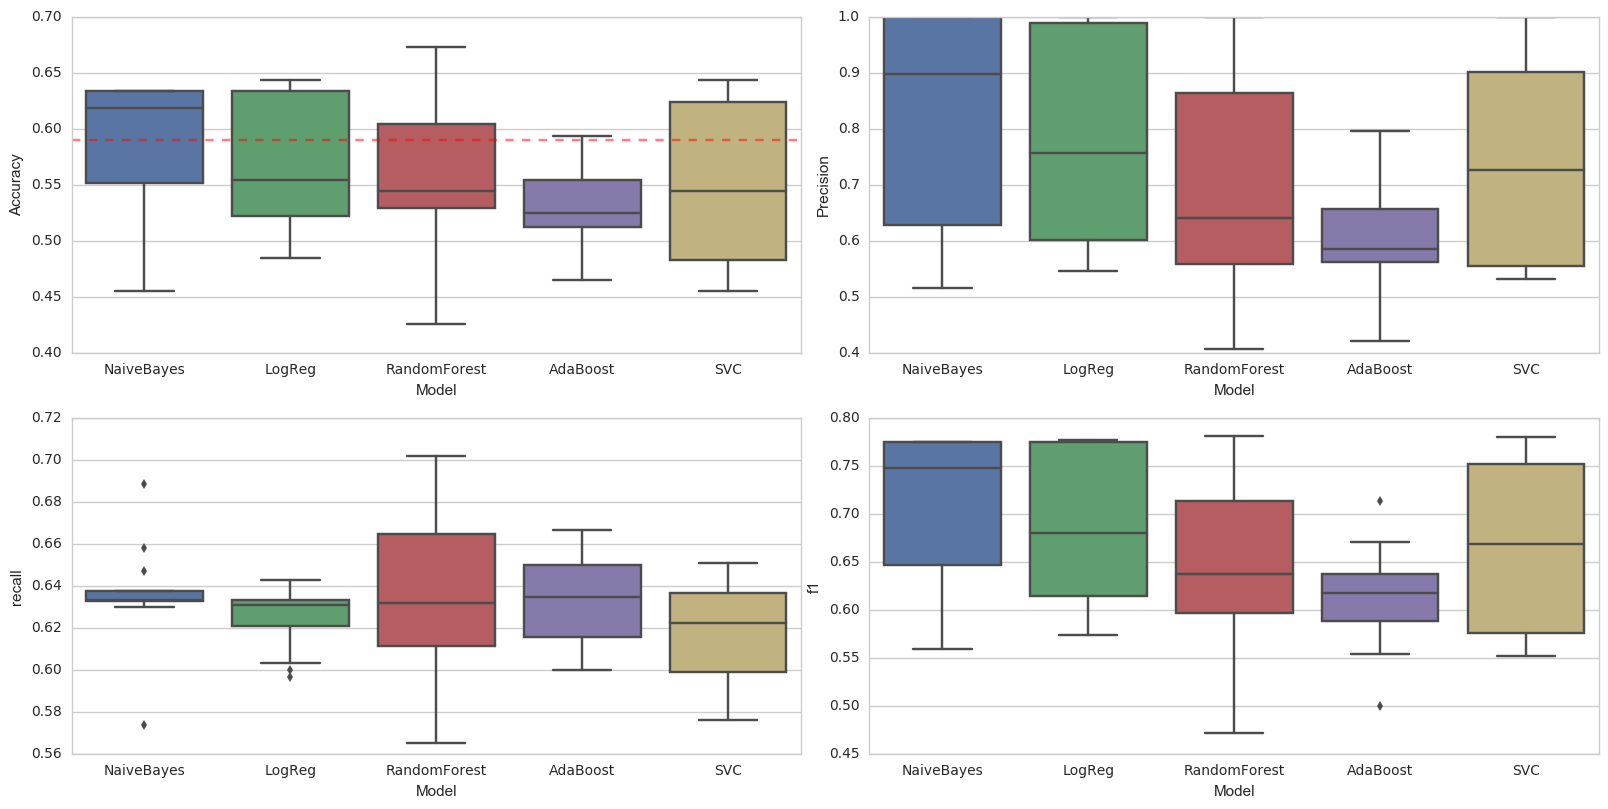

In [123]:
f, ax = plt.subplots(figsize=(16, 8));

ax1 = plt.subplot2grid((2,2),(0,0));
ax1 = sns.boxplot(x='model',y='accuracy',data=Model_Assessments[Model_Assessments.sample_source=='test']);
plt.xlabel('Model');plt.ylabel('Accuracy');plt.axhline(y=0.59,ls='dashed',alpha=0.5,color='r');

ax2 = plt.subplot2grid((2,2),(0,1));
ax2 = sns.boxplot(x='model',y='precision',data=Model_Assessments[Model_Assessments.sample_source=='test']);
plt.xlabel('Model');plt.ylabel('Precision');

ax3 = plt.subplot2grid((2,2),(1,0));
ax3 = sns.boxplot(x='model',y='recall',data=Model_Assessments[Model_Assessments.sample_source=='test']);
plt.xlabel('Model');plt.ylabel('recall');

ax4 = plt.subplot2grid((2,2),(1,1));
ax4 = sns.boxplot(x='model',y='f1',data=Model_Assessments[Model_Assessments.sample_source=='test']);
plt.xlabel('Model');plt.ylabel('f1');

plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0);

#OUT-OF-SAMPLE TEST PERFORMANCE
#red line shows null model accuracy

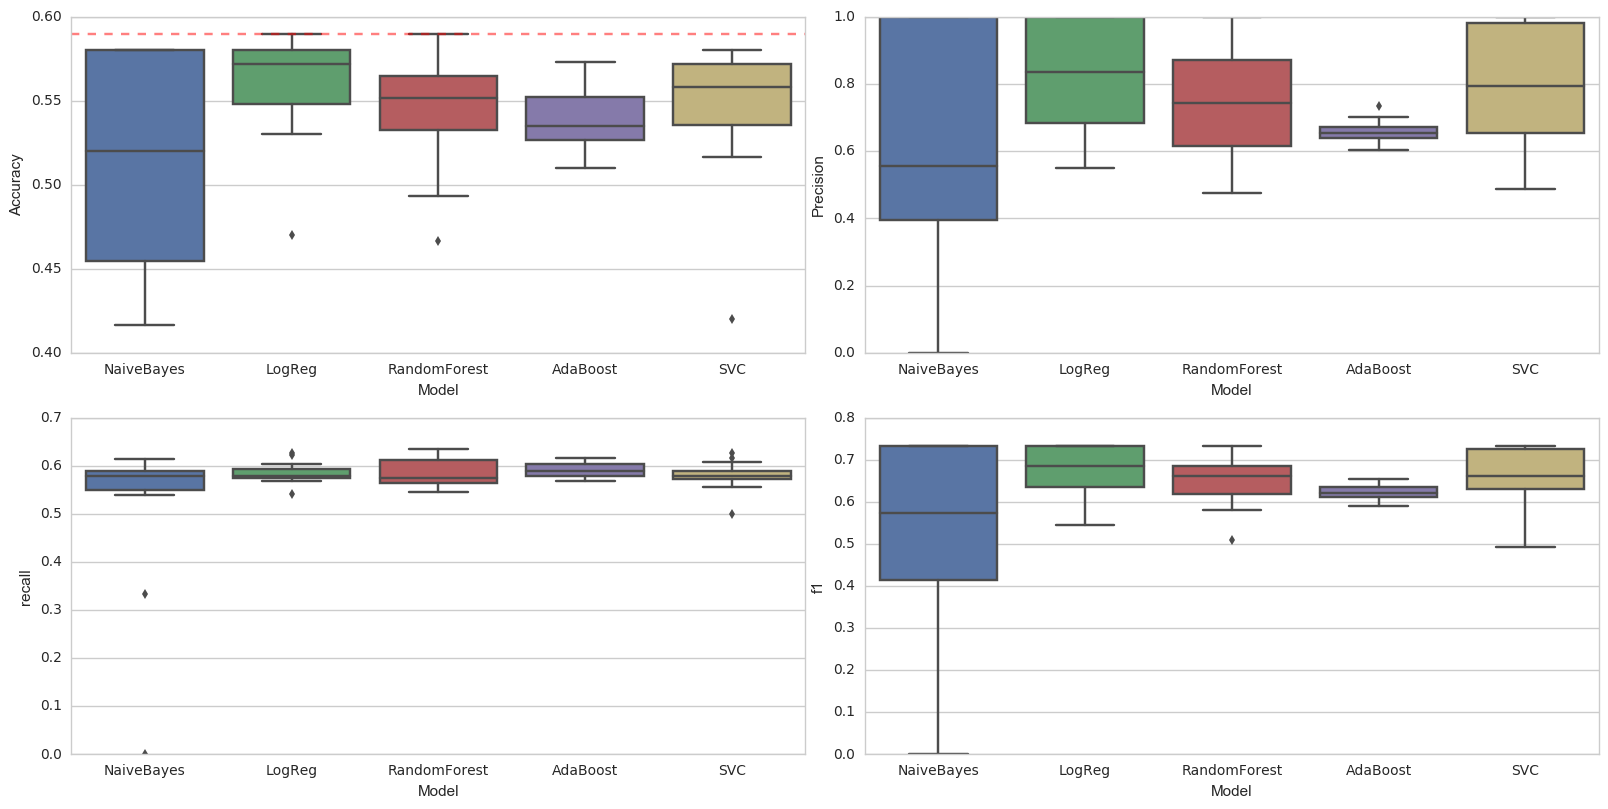

In [126]:
f, ax = plt.subplots(figsize=(16, 8));

ax1 = plt.subplot2grid((2,2),(0,0));
ax1 = sns.boxplot(x='model',y='accuracy',data=Model_Assessments[Model_Assessments.sample_source=='CV']);
plt.xlabel('Model');plt.ylabel('Accuracy');plt.axhline(y=0.59,ls='dashed',alpha=0.5,color='r');

ax2 = plt.subplot2grid((2,2),(0,1));
ax2 = sns.boxplot(x='model',y='precision',data=Model_Assessments[Model_Assessments.sample_source=='CV']);
plt.xlabel('Model');plt.ylabel('Precision');

ax3 = plt.subplot2grid((2,2),(1,0));
ax3 = sns.boxplot(x='model',y='recall',data=Model_Assessments[Model_Assessments.sample_source=='CV']);
plt.xlabel('Model');plt.ylabel('recall');

ax4 = plt.subplot2grid((2,2),(1,1));
ax4 = sns.boxplot(x='model',y='f1',data=Model_Assessments[Model_Assessments.sample_source=='CV']);
plt.xlabel('Model');plt.ylabel('f1');

plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0);

#CROSS-VALIDATION SAMPLES
#red line shows null model accuracy

**adaboot performs the worst, and takes longest to run, so I'll plan to remove it from step 6, below**

**Show ROC curves and Confusion Matrices for best model in each test category by accuracy, and best model in each CV category by f1 score**

From examing predictions from these models, I found that precision==1 is associated with the null model (predicting all 1s), so I only want to consider models that have precision!=1.0

In [171]:
#Best CV NB model
Model_Assessments[(Model_Assessments.precision!=1.0) & (Model_Assessments.model=='NaiveBayes') & (Model_Assessments.f1 == Model_Assessments[(Model_Assessments.precision!=1.0) & (Model_Assessments.sample_source=='CV') & (Model_Assessments.model=='NaiveBayes')].f1.max())]

,sample_source,model_name,vectorizer_index,accuracy,precision,recall,f1,model
2,CV,"MultinomialNB(alpha=1.0, class_prior=None, fit...",1,0.496667,0.672414,0.554502,0.607792,NaiveBayes


In [172]:
#Best CV LogReg model
Model_Assessments[(Model_Assessments.precision!=1.0) & (Model_Assessments.model=='LogReg') & (Model_Assessments.f1 == Model_Assessments[(Model_Assessments.precision!=1.0) & (Model_Assessments.sample_source=='CV') & (Model_Assessments.model=='LogReg')].f1.max())]

,sample_source,model_name,vectorizer_index,accuracy,precision,recall,f1,model
34,CV,"LogisticRegression(C=1.0, class_weight=None, d...",5,0.573333,0.988506,0.577181,0.728814,LogReg


In [173]:
#Best CV RandomForest model
Model_Assessments[(Model_Assessments.precision!=1.0) & (Model_Assessments.model=='RandomForest') & (Model_Assessments.f1 == Model_Assessments[(Model_Assessments.precision!=1.0) & (Model_Assessments.sample_source=='CV') & (Model_Assessments.model=='RandomForest')].f1.max())]

,sample_source,model_name,vectorizer_index,accuracy,precision,recall,f1,model
62,CV,"RandomForestClassifier(bootstrap=True, class_w...",7,0.546667,0.87931,0.570896,0.692308,RandomForest


In [174]:
#Best CV AdaBoost model
Model_Assessments[(Model_Assessments.precision!=1.0) & (Model_Assessments.model=='AdaBoost') & (Model_Assessments.f1 == Model_Assessments[(Model_Assessments.precision!=1.0) & (Model_Assessments.sample_source=='CV') & (Model_Assessments.model=='AdaBoost')].f1.max())]

,sample_source,model_name,vectorizer_index,accuracy,precision,recall,f1,model
82,CV,"AdaBoostClassifier(algorithm='SAMME.R', base_e...",5,0.573333,0.701149,0.616162,0.655914,AdaBoost


In [175]:
#Best CV SVC model
Model_Assessments[(Model_Assessments.precision!=1.0) & (Model_Assessments.model=='SVC') & (Model_Assessments.f1 == Model_Assessments[(Model_Assessments.precision!=1.0) & (Model_Assessments.sample_source=='CV') & (Model_Assessments.model=='SVC')].f1.max())]

,sample_source,model_name,vectorizer_index,accuracy,precision,recall,f1,model
118,CV,"LinearSVC(C=1.0, class_weight=None, dual=True,...",11,0.576667,0.994253,0.578595,0.731501,SVC


In [176]:
#Best test NB model
Model_Assessments[(Model_Assessments.precision!=1.0) & (Model_Assessments.model=='NaiveBayes') & (Model_Assessments.f1 == Model_Assessments[(Model_Assessments.precision!=1.0) & (Model_Assessments.sample_source=='test') & (Model_Assessments.model=='NaiveBayes')].f1.max())]

,sample_source,model_name,vectorizer_index,accuracy,precision,recall,f1,model
7,test,"MultinomialNB(alpha=1.0, class_prior=None, fit...",3,0.623762,0.984375,0.63,0.768293,NaiveBayes


In [177]:
#Best test LogReg model
Model_Assessments[(Model_Assessments.precision!=1.0) & (Model_Assessments.model=='LogReg') & (Model_Assessments.f1 == Model_Assessments[(Model_Assessments.precision!=1.0) & (Model_Assessments.sample_source=='test') & (Model_Assessments.model=='LogReg')].f1.max())]

,sample_source,model_name,vectorizer_index,accuracy,precision,recall,f1,model
41,test,"LogisticRegression(C=1.0, class_weight=None, d...",8,0.643564,0.984375,0.642857,0.777778,LogReg


In [178]:
#Best test RandomForest model
Model_Assessments[(Model_Assessments.precision!=1.0) & (Model_Assessments.model=='RandomForest') & (Model_Assessments.f1 == Model_Assessments[(Model_Assessments.precision!=1.0) & (Model_Assessments.sample_source=='test') & (Model_Assessments.model=='RandomForest')].f1.max())]

,sample_source,model_name,vectorizer_index,accuracy,precision,recall,f1,model
55,test,"RandomForestClassifier(bootstrap=True, class_w...",3,0.673267,0.921875,0.678161,0.781457,RandomForest


In [179]:
#Best test AdaBoost model
Model_Assessments[(Model_Assessments.precision!=1.0) & (Model_Assessments.model=='AdaBoost') & (Model_Assessments.f1 == Model_Assessments[(Model_Assessments.precision!=1.0) & (Model_Assessments.sample_source=='test') & (Model_Assessments.model=='AdaBoost')].f1.max())]

,sample_source,model_name,vectorizer_index,accuracy,precision,recall,f1,model
83,test,"AdaBoostClassifier(algorithm='SAMME.R', base_e...",5,0.594059,0.796875,0.64557,0.713287,AdaBoost


In [180]:
#Best test SVC model
Model_Assessments[(Model_Assessments.precision!=1.0) & (Model_Assessments.model=='SVC') & (Model_Assessments.f1 == Model_Assessments[(Model_Assessments.precision!=1.0) & (Model_Assessments.sample_source=='test') & (Model_Assessments.model=='SVC')].f1.max())]

,sample_source,model_name,vectorizer_index,accuracy,precision,recall,f1,model
107,test,"LinearSVC(C=1.0, class_weight=None, dual=True,...",5,0.623762,0.984375,0.63,0.768293,SVC


In [181]:
top_models_CV_indices = [2,34,62,82,118]
top_models_CV = Model_Assessments.iloc[top_models_CV_indices]
top_models_CV

,sample_source,model_name,vectorizer_index,accuracy,precision,recall,f1,model
2,CV,"MultinomialNB(alpha=1.0, class_prior=None, fit...",1,0.496667,0.672414,0.554502,0.607792,NaiveBayes
34,CV,"LogisticRegression(C=1.0, class_weight=None, d...",5,0.573333,0.988506,0.577181,0.728814,LogReg
62,CV,"RandomForestClassifier(bootstrap=True, class_w...",7,0.546667,0.879310,0.570896,0.692308,RandomForest
82,CV,"AdaBoostClassifier(algorithm='SAMME.R', base_e...",5,0.573333,0.701149,0.616162,0.655914,AdaBoost
118,CV,"LinearSVC(C=1.0, class_weight=None, dual=True,...",11,0.576667,0.994253,0.578595,0.731501,SVC


In [182]:
top_models_test_indices = [7,41,55,83,107]
top_models_test = Model_Assessments.iloc[top_models_test_indices]
top_models_test

,sample_source,model_name,vectorizer_index,accuracy,precision,recall,f1,model
7,test,"MultinomialNB(alpha=1.0, class_prior=None, fit...",3,0.623762,0.984375,0.630000,0.768293,NaiveBayes
41,test,"LogisticRegression(C=1.0, class_weight=None, d...",8,0.643564,0.984375,0.642857,0.777778,LogReg
55,test,"RandomForestClassifier(bootstrap=True, class_w...",3,0.673267,0.921875,0.678161,0.781457,RandomForest
83,test,"AdaBoostClassifier(algorithm='SAMME.R', base_e...",5,0.594059,0.796875,0.645570,0.713287,AdaBoost
107,test,"LinearSVC(C=1.0, class_weight=None, dual=True,...",5,0.623762,0.984375,0.630000,0.768293,SVC


In [274]:
#prepping dataframe for part 8
ensemble_predictions = pd.DataFrame([])

In [277]:
top_model_NB1 = MultinomialNB()
top_model_NB1.fit(doc_term_matrices[1]['train'],yTrain)
predictions = top_model_NB1.predict_proba(doc_term_matrices[1]['test'])
predictions_ = top_model_NB1.predict(doc_term_matrices[1]['test'])
NB1_fpr, NB1_tpr, thresholds = roc_curve(yTest,predictions[:,1])
CM_ = np.asarray([[0,1],[1,0]]).dot(confusion_matrix(predictions_,yTest)).dot(np.asarray([[0,1],[1,0]])).T
CM = pd.DataFrame(CM_,columns=['Predicted +','Predicted -'])
CM.index = ['Actual +','Actual -']
print('NB1')
print(CM,'\n\n\n')
preds_for_df = list(predictions[:,1])
preds_for_df.extend(list(top_model_NB1.predict_proba(doc_term_matrices[1]['train'])[:,1]))
ensemble_predictions['NB_allWords'] = preds_for_df

top_model_NB2 = MultinomialNB()
top_model_NB2.fit(doc_term_matrices[3]['train'],yTrain)
predictions = top_model_NB2.predict_proba(doc_term_matrices[3]['test'])
predictions_ = top_model_NB2.predict(doc_term_matrices[3]['test'])
NB2_fpr, NB2_tpr, thresholds = roc_curve(yTest,predictions[:,1])
CM_ = np.asarray([[0,1],[1,0]]).dot(confusion_matrix(predictions_,yTest)).dot(np.asarray([[0,1],[1,0]])).T
CM = pd.DataFrame(CM_,columns=['Predicted +','Predicted -'])
CM.index = ['Actual +','Actual -']
print('NB2')
print(CM,'\n\n\n')

top_model_LR1 = LogisticRegression()
top_model_LR1.fit(doc_term_matrices[5]['train'],yTrain)
predictions = top_model_LR1.predict_proba(doc_term_matrices[5]['test'])
predictions_ = top_model_LR1.predict(doc_term_matrices[5]['test'])
LR1_fpr, LR1_tpr, thresholds = roc_curve(yTest,predictions[:,1])
CM_ = np.asarray([[0,1],[1,0]]).dot(confusion_matrix(predictions_,yTest)).dot(np.asarray([[0,1],[1,0]])).T
CM = pd.DataFrame(CM_,columns=['Predicted +','Predicted -'])
CM.index = ['Actual +','Actual -']
print('LR1')
print(CM,'\n\n\n')

top_model_LR2 = LogisticRegression()
top_model_LR2.fit(doc_term_matrices[8]['train'],yTrain)
predictions = top_model_LR2.predict_proba(doc_term_matrices[8]['test'])
predictions_ = top_model_LR2.predict(doc_term_matrices[8]['test'])
LR2_fpr, LR2_tpr, thresholds = roc_curve(yTest,predictions[:,1])
CM_ = np.asarray([[0,1],[1,0]]).dot(confusion_matrix(predictions_,yTest)).dot(np.asarray([[0,1],[1,0]])).T
CM = pd.DataFrame(CM_,columns=['Predicted +','Predicted -'])
CM.index = ['Actual +','Actual -']
print('LR2')
print(CM,'\n\n\n')

top_model_RF1 = RandomForestClassifier()
top_model_RF1.fit(doc_term_matrices[7]['train'],yTrain)
predictions = top_model_RF1.predict_proba(doc_term_matrices[7]['test'])
predictions_ = top_model_RF1.predict(doc_term_matrices[7]['test'])
RF1_fpr, RF1_tpr, thresholds = roc_curve(yTest,predictions[:,1])
CM_ = np.asarray([[0,1],[1,0]]).dot(confusion_matrix(predictions_,yTest)).dot(np.asarray([[0,1],[1,0]])).T
CM = pd.DataFrame(CM_,columns=['Predicted +','Predicted -'])
CM.index = ['Actual +','Actual -']
print('RF1')
print(CM,'\n\n\n')
preds_for_df = list(predictions[:,1])
preds_for_df.extend(list(top_model_RF1.predict_proba(doc_term_matrices[7]['train'])[:,1]))
ensemble_predictions['RF_allWords'] = preds_for_df

top_model_RF2 = RandomForestClassifier()
top_model_RF2.fit(doc_term_matrices[3]['train'],yTrain)
predictions = top_model_RF2.predict_proba(doc_term_matrices[3]['test'])
predictions_ = top_model_RF2.predict(doc_term_matrices[3]['test'])
RF2_fpr, RF2_tpr, thresholds = roc_curve(yTest,predictions[:,1])
CM_ = np.asarray([[0,1],[1,0]]).dot(confusion_matrix(predictions_,yTest)).dot(np.asarray([[0,1],[1,0]])).T
CM = pd.DataFrame(CM_,columns=['Predicted +','Predicted -'])
CM.index = ['Actual +','Actual -']
print('RF2')
print(CM,'\n\n\n')

top_model_AB = AdaBoostClassifier()
top_model_AB.fit(doc_term_matrices[5]['train'],yTrain)
predictions = top_model_AB.predict_proba(doc_term_matrices[5]['test'])
predictions_ = top_model_AB.predict(doc_term_matrices[5]['test'])
AB_fpr, AB_tpr, thresholds = roc_curve(yTest,predictions[:,1])
CM_ = np.asarray([[0,1],[1,0]]).dot(confusion_matrix(predictions_,yTest)).dot(np.asarray([[0,1],[1,0]])).T
CM = pd.DataFrame(CM_,columns=['Predicted +','Predicted -'])
CM.index = ['Actual +','Actual -']
print('AB')
print(CM,'\n\n\n')
preds_for_df = list(predictions[:,1])
preds_for_df.extend(list(top_model_AB.predict_proba(doc_term_matrices[5]['train'])[:,1]))
ensemble_predictions['AB_allWords'] = preds_for_df

top_model_SV1 = LinearSVC()
top_model_SV1.fit(doc_term_matrices[11]['train'],yTrain)
predictions = top_model_SV1.predict(doc_term_matrices[11]['test'])
predictions_ = top_model_SV1.predict(doc_term_matrices[11]['test'])
SV1_fpr, SV1_tpr, thresholds = roc_curve(yTest,predictions)
CM_ = np.asarray([[0,1],[1,0]]).dot(confusion_matrix(predictions_,yTest)).dot(np.asarray([[0,1],[1,0]])).T
CM = pd.DataFrame(CM_,columns=['Predicted +','Predicted -'])
CM.index = ['Actual +','Actual -']
print('SV1')
print(CM,'\n\n\n')

top_model_SV2 = LinearSVC()
top_model_SV2.fit(doc_term_matrices[5]['train'],yTrain)
predictions = top_model_SV2.predict(doc_term_matrices[5]['test'])
predictions_ = top_model_SV2.predict(doc_term_matrices[5]['test'])
SV2_fpr, SV2_tpr, thresholds = roc_curve(yTest,predictions)
CM_ = np.asarray([[0,1],[1,0]]).dot(confusion_matrix(predictions_,yTest)).dot(np.asarray([[0,1],[1,0]])).T
CM = pd.DataFrame(CM_,columns=['Predicted +','Predicted -'])
CM.index = ['Actual +','Actual -']
print('SV2')
print(CM)

NB1
          Predicted +  Predicted -
Actual +           48           16
Actual -           28            9 



NB2
          Predicted +  Predicted -
Actual +           63            1
Actual -           37            0 



LR1
          Predicted +  Predicted -
Actual +           63            1
Actual -           37            0 



LR2
          Predicted +  Predicted -
Actual +           63            1
Actual -           35            2 



RF1
          Predicted +  Predicted -
Actual +           59            5
Actual -           34            3 



RF2
          Predicted +  Predicted -
Actual +           59            5
Actual -           35            2 



AB
          Predicted +  Predicted -
Actual +           50           14
Actual -           26           11 



SV1
          Predicted +  Predicted -
Actual +           56            8
Actual -           30            7 



SV2
          Predicted +  Predicted -
Actual +           63            1
Actual -           37  

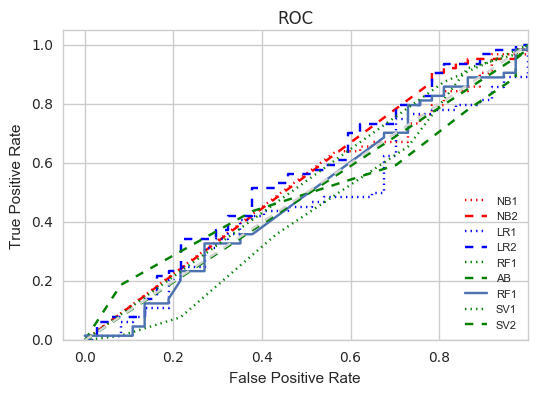

In [268]:
### Plot ROC curve for top model of each model type
plt.title('ROC');
plt.plot(NB1_fpr, NB1_tpr,color='r',label='NB1',linestyle='dotted');
plt.plot(NB2_fpr, NB2_tpr,color='r',label='NB2',linestyle='dashed');
plt.plot(LR1_fpr, LR1_tpr,color='b',label='LR1',linestyle='dotted');
plt.plot(LR2_fpr, LR2_tpr,color='b',label='LR2',linestyle='dashed');
plt.plot(RF1_fpr, RF1_tpr,color='g',label='RF1',linestyle='dotted');
plt.plot(RF2_fpr, RF2_tpr,color='g',label='AB',linestyle='dashed');
plt.plot(AB_fpr, AB_tpr,label='RF1');
plt.plot(SV1_fpr, SV1_tpr,color='g',label='SV1',linestyle='dotted');
plt.plot(SV2_fpr, SV2_tpr,color='g',label='SV2',linestyle='dashed');
plt.legend(loc='lower right', prop={'size':8});
plt.plot([0,1],[0,1], color='lightgrey', linestyle='--');
plt.xlim([-0.05,1.0]);
plt.ylim([0.0,1.05]);
plt.ylabel('True Positive Rate');
plt.xlabel('False Positive Rate');

# 6. Create new corpus based on badwords, EDA of badword_corpus

**Add badword content** bad-words.txt was obtained from https://www.cs.cmu.edu/~biglou/resources/ 

In [218]:
bad_words = list(pd.read_csv('bad-words.txt').iloc[:,0])

script_lines_ = list(data_df.content)

bw_filtered_scripts = []
for script in script_lines_:
    badword_script = ''
    for badword in bad_words:
        if badword in script:
            bw_match = [(m.start(0), m.end(0)) for m in re.finditer(badword+' ',script)]
            for match in bw_match:
                badword_script = badword_script+script[match[0]:match[1]]+' '
    bw_filtered_scripts.append(badword_script)

data_df['badword_content'] = bw_filtered_scripts

In [219]:
badword_counts = []
for script in script_lines_:
    count = 0
    for badword in bad_words:
        if badword+' ' in script:
            count+=1
    badword_counts.append(count)
badword_counts[:12]

[27, 14, 28, 44, 45, 53, 22, 30, 27, 22, 48, 0]

/Users/lukebawazer/anaconda/envs/nlp/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


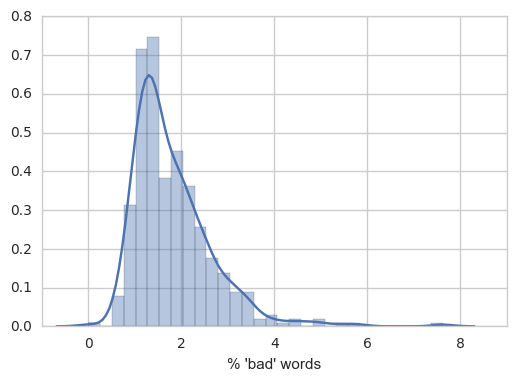

In [221]:
percent_badwords = [100*(len(bw_filtered_scripts[i])/len(script_lines_[i])) for i in range(len(script_lines))]
sns.distplot(percent_badwords);
plt.xlabel('% \'bad\' words');

In [222]:
data_df['percent_badwords'] = percent_badwords
top_badword_movie_refnums = list(data_df[data_df.percent_badwords>4].movie_ref)
for ref in top_badword_movie_refnums:
    print(list(movies_refnums.keys())[list(movies_refnums.values()).index(ref)])

platoon
kids
the negotiator
fear and loathing in las vegas
the boondock saints
south park: bigger longer & uncut
unforgiven
the big lebowski
reservoir dogs


(-0.3, 8)

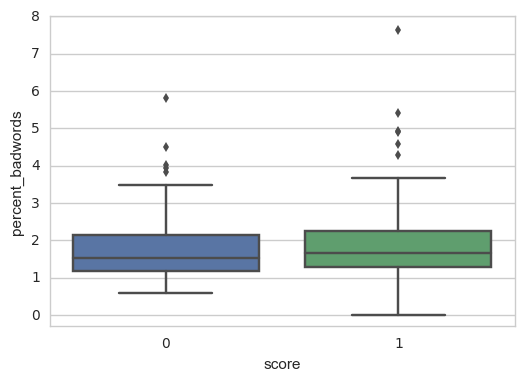

In [223]:
sns.boxplot(x='score',y='percent_badwords',data=data_df);
plt.ylim([-0.3,8])

# 7. Repeat 4 and 5, but with the badword corpus

In [279]:
#TRAIN TEST SPLIT
xTrain, xTest, yTrain, yTest = train_test_split(data_df.badword_content,
                                              data_df.score,
                                              random_state=42,
                                               train_size=0.75)

#GENERATE A VARIETY OF VECTORIZED MATRICES
    
#Make 8 Count_Vectorizers and 4 TFIDF Vectorizers 
Vectorizers = []
Vectorizers.append(CountVectorizer(analyzer='word',ngram_range=(1,1),
                        stop_words='english',max_features=1000))
Vectorizers.append(CountVectorizer(analyzer='word',ngram_range=(1,1),
                        stop_words='english',max_features=None))
Vectorizers.append(CountVectorizer(analyzer='word',ngram_range=(2,2),
                        stop_words='english',max_features=1000))
Vectorizers.append(CountVectorizer(analyzer='word',ngram_range=(2,2),
                        stop_words='english',max_features=None))
Vectorizers.append(CountVectorizer(analyzer='word',ngram_range=(3,3),
                        stop_words='english',max_features=1000))
Vectorizers.append(CountVectorizer(analyzer='word',ngram_range=(3,3),
                        stop_words='english',max_features=None))
Vectorizers.append(CountVectorizer(analyzer='word',ngram_range=(1,5),
                        stop_words='english',max_features=1000))
Vectorizers.append(CountVectorizer(analyzer='word',ngram_range=(1,5),
                        stop_words='english',max_features=None))
Vectorizers.append(TfidfVectorizer(encoding='Windows-1252',analyzer='word',ngram_range=(1,1),stop_words='english'))
Vectorizers.append(TfidfVectorizer(encoding='Windows-1252',analyzer='word',ngram_range=(2,2),stop_words='english'))
Vectorizers.append(TfidfVectorizer(encoding='Windows-1252',analyzer='word',ngram_range=(3,3),stop_words='english'))
Vectorizers.append(TfidfVectorizer(encoding='Windows-1252',analyzer='word',ngram_range=(1,5),stop_words='english'))

#Make a list of 2-element dicts--train,test doc-term matrices--for each vectorizer  
doc_term_matrices = []
for vectorizer in Vectorizers:
    doc_term_dict_ = {}
    doc_term_dict_['train'] = vectorizer.fit_transform(xTrain)
    doc_term_dict_['test'] = vectorizer.transform(xTest)
    doc_term_matrices.append(doc_term_dict_)

In [281]:
for i in range(len(doc_term_matrices)):
    print(doc_term_matrices[i]['train'].shape)
    print(doc_term_matrices[i]['test'].shape)

(300, 489)
(101, 489)
(300, 489)
(101, 489)
(300, 1000)
(101, 1000)
(300, 3069)
(101, 3069)
(300, 1000)
(101, 1000)
(300, 6254)
(101, 6254)
(300, 1000)
(101, 1000)
(300, 29710)
(101, 29710)
(300, 489)
(101, 489)
(300, 3069)
(101, 3069)
(300, 6254)
(101, 6254)
(300, 29710)
(101, 29710)


In [226]:
models_ = [MultinomialNB(),LogisticRegression(),RandomForestClassifier(),AdaBoostClassifier(),LinearSVC()]

sample_source = []
model_name = []
vectorizer_index = []
accuracy = []
precision = []
recall = []
f1 = []
#loop through each model with default params
for model in models_:
    #for each model, loop through each doc-term matrix
    for i in range(len(doc_term_matrices)):
        #get scores from both CV and test samples
        sample_source.append('CV')
        predictions = cross_val_predict(model,doc_term_matrices[i]['train'],yTrain,cv=3)
        model_name.append(str(model))
        vectorizer_index.append(i)
        accuracy.append(accuracy_score(predictions,yTrain))
        precision.append(precision_score(predictions,yTrain))
        recall.append(recall_score(predictions,yTrain))
        f1.append(f1_score(predictions,yTrain))
        
        sample_source.append('test')
        model.fit(doc_term_matrices[i]['train'],yTrain)
        predictions = model.predict(doc_term_matrices[i]['test'])
        model_name.append(str(model))
        vectorizer_index.append(i)
        accuracy.append(accuracy_score(predictions,yTest))
        precision.append(precision_score(predictions,yTest))
        recall.append(recall_score(predictions,yTest))
        f1.append(f1_score(predictions,yTest))

#load results to dataframe for viewing and plotting
Model_Assessments = pd.DataFrame([])
Model_Assessments['sample_source'] = sample_source
Model_Assessments['model_name'] = model_name
Model_Assessments['vectorizer_index'] = vectorizer_index
Model_Assessments['accuracy'] = accuracy
Model_Assessments['precision'] = precision
Model_Assessments['recall'] = recall
Model_Assessments['f1'] = f1

In [227]:
#edit model names (for display)
new_model_name = []
for model_name in Model_Assessments.model_name:
    if 'MultinomialNB' in model_name: new_model_name.append('NaiveBayes')
    elif 'RandomForest' in model_name: new_model_name.append('RandomForest')
    elif 'LogisticRegression' in model_name: new_model_name.append('LogReg')
    elif 'AdaBoost' in model_name: new_model_name.append('AdaBoost')
    elif 'LinearSVC' in model_name: new_model_name.append('SVC')
Model_Assessments['model'] = new_model_name

In [228]:
#Quick look at the best model by accuracy
Model_Assessments[Model_Assessments.accuracy==Model_Assessments.accuracy.max()]

,sample_source,model_name,vectorizer_index,accuracy,precision,recall,f1,model
41,test,"LogisticRegression(C=1.0, class_weight=None, d...",8,0.653465,0.90625,0.666667,0.768212,LogReg
47,test,"LogisticRegression(C=1.0, class_weight=None, d...",11,0.653465,0.96875,0.652632,0.779874,LogReg


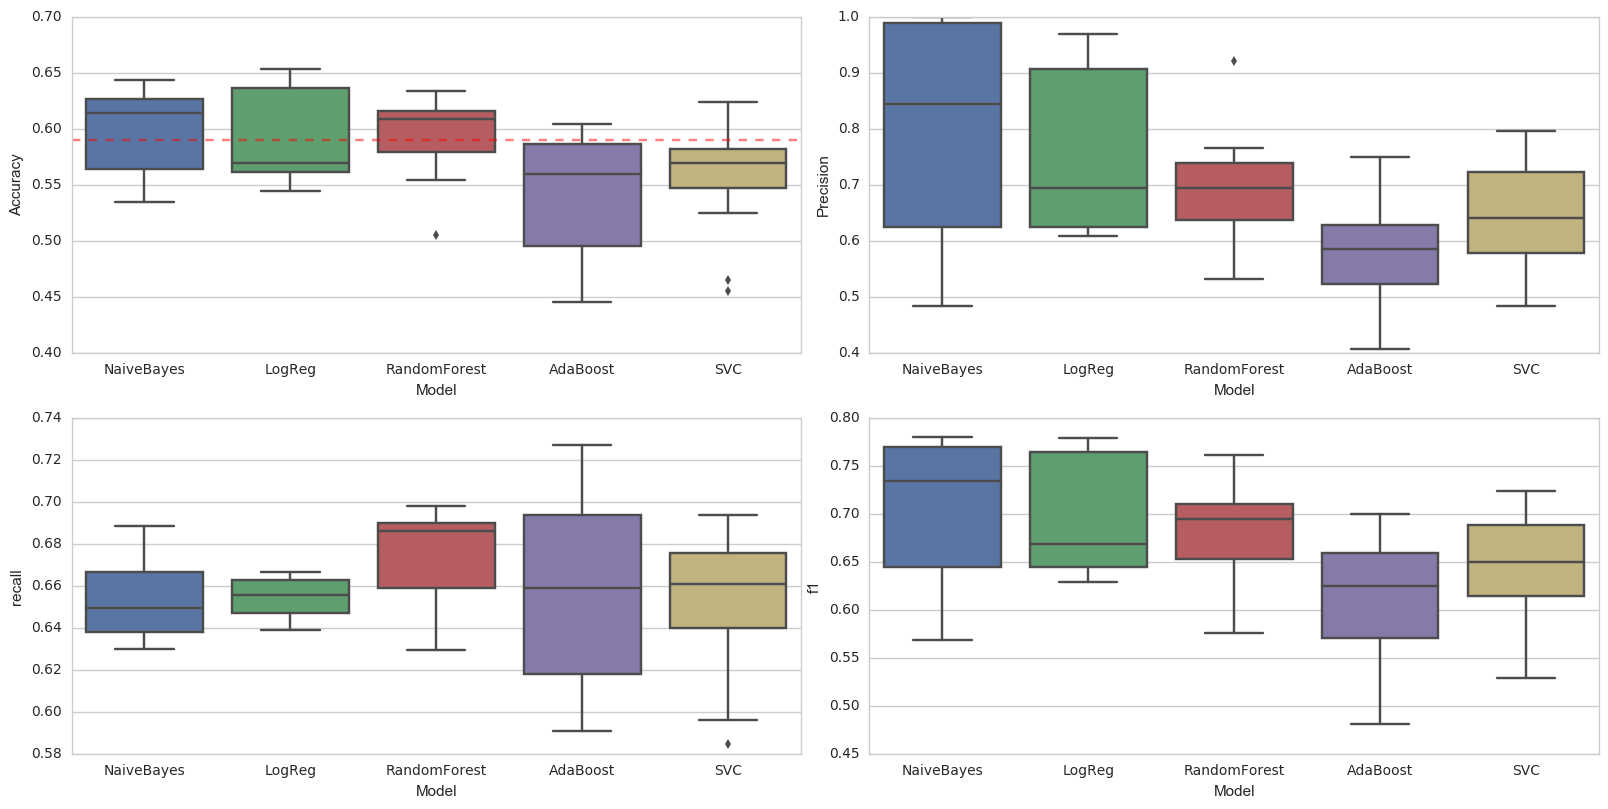

In [229]:
f, ax = plt.subplots(figsize=(16, 8));

ax1 = plt.subplot2grid((2,2),(0,0));
ax1 = sns.boxplot(x='model',y='accuracy',data=Model_Assessments[Model_Assessments.sample_source=='test']);
plt.xlabel('Model');plt.ylabel('Accuracy');plt.axhline(y=0.59,ls='dashed',alpha=0.5,color='r');

ax2 = plt.subplot2grid((2,2),(0,1));
ax2 = sns.boxplot(x='model',y='precision',data=Model_Assessments[Model_Assessments.sample_source=='test']);
plt.xlabel('Model');plt.ylabel('Precision');

ax3 = plt.subplot2grid((2,2),(1,0));
ax3 = sns.boxplot(x='model',y='recall',data=Model_Assessments[Model_Assessments.sample_source=='test']);
plt.xlabel('Model');plt.ylabel('recall');

ax4 = plt.subplot2grid((2,2),(1,1));
ax4 = sns.boxplot(x='model',y='f1',data=Model_Assessments[Model_Assessments.sample_source=='test']);
plt.xlabel('Model');plt.ylabel('f1');

plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0);

#OUT-OF-SAMPLE TEST PERFORMANCE
#red line shows null model accuracy

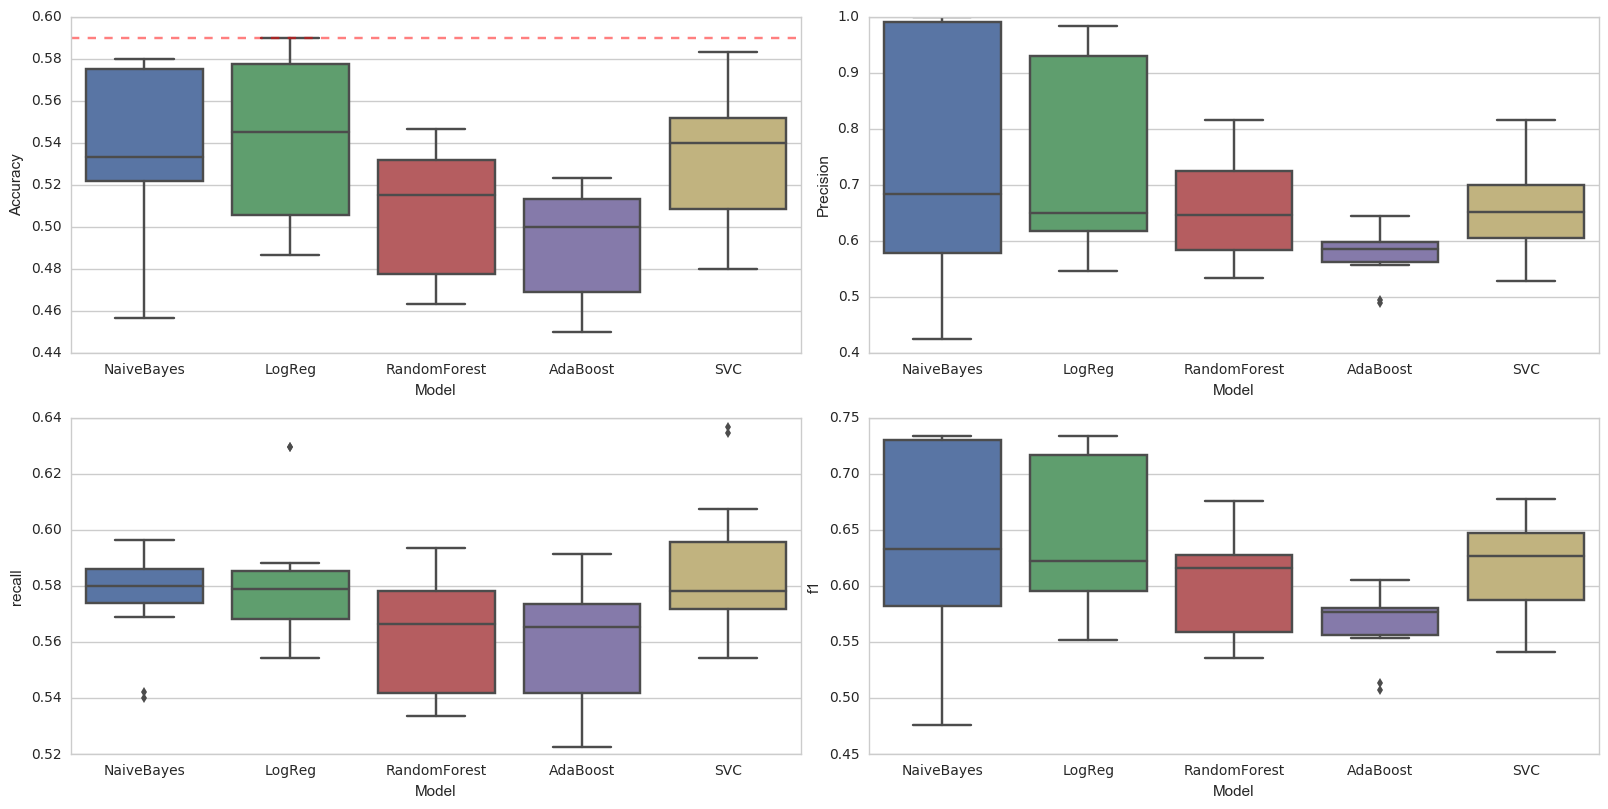

In [230]:
f, ax = plt.subplots(figsize=(16, 8));

ax1 = plt.subplot2grid((2,2),(0,0));
ax1 = sns.boxplot(x='model',y='accuracy',data=Model_Assessments[Model_Assessments.sample_source=='CV']);
plt.xlabel('Model');plt.ylabel('Accuracy');plt.axhline(y=0.59,ls='dashed',alpha=0.5,color='r');

ax2 = plt.subplot2grid((2,2),(0,1));
ax2 = sns.boxplot(x='model',y='precision',data=Model_Assessments[Model_Assessments.sample_source=='CV']);
plt.xlabel('Model');plt.ylabel('Precision');

ax3 = plt.subplot2grid((2,2),(1,0));
ax3 = sns.boxplot(x='model',y='recall',data=Model_Assessments[Model_Assessments.sample_source=='CV']);
plt.xlabel('Model');plt.ylabel('recall');

ax4 = plt.subplot2grid((2,2),(1,1));
ax4 = sns.boxplot(x='model',y='f1',data=Model_Assessments[Model_Assessments.sample_source=='CV']);
plt.xlabel('Model');plt.ylabel('f1');

plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0);

#CROSS-VALIDATION SAMPLES
#red line shows null model accuracy

In [231]:
#Best CV NB model
Model_Assessments[(Model_Assessments.precision!=1.0) & (Model_Assessments.model=='NaiveBayes') & (Model_Assessments.f1 == Model_Assessments[(Model_Assessments.precision!=1.0) & (Model_Assessments.sample_source=='CV') & (Model_Assessments.model=='NaiveBayes')].f1.max())]

,sample_source,model_name,vectorizer_index,accuracy,precision,recall,f1,model
16,CV,"MultinomialNB(alpha=1.0, class_prior=None, fit...",8,0.573333,0.988506,0.577181,0.728814,NaiveBayes


In [232]:
#Best CV LogReg model
Model_Assessments[(Model_Assessments.precision!=1.0) & (Model_Assessments.model=='LogReg') & (Model_Assessments.f1 == Model_Assessments[(Model_Assessments.precision!=1.0) & (Model_Assessments.sample_source=='CV') & (Model_Assessments.model=='LogReg')].f1.max())]

,sample_source,model_name,vectorizer_index,accuracy,precision,recall,f1,model
42,CV,"LogisticRegression(C=1.0, class_weight=None, d...",9,0.59,0.977011,0.588235,0.734341,LogReg


In [233]:
#Best CV RandomForest model
Model_Assessments[(Model_Assessments.precision!=1.0) & (Model_Assessments.model=='RandomForest') & (Model_Assessments.f1 == Model_Assessments[(Model_Assessments.precision!=1.0) & (Model_Assessments.sample_source=='CV') & (Model_Assessments.model=='RandomForest')].f1.max())]

,sample_source,model_name,vectorizer_index,accuracy,precision,recall,f1,model
58,CV,"RandomForestClassifier(bootstrap=True, class_w...",5,0.546667,0.816092,0.577236,0.67619,RandomForest


In [234]:
#Best CV AdaBoost model
Model_Assessments[(Model_Assessments.precision!=1.0) & (Model_Assessments.model=='AdaBoost') & (Model_Assessments.f1 == Model_Assessments[(Model_Assessments.precision!=1.0) & (Model_Assessments.sample_source=='CV') & (Model_Assessments.model=='AdaBoost')].f1.max())]

,sample_source,model_name,vectorizer_index,accuracy,precision,recall,f1,model
94,CV,"AdaBoostClassifier(algorithm='SAMME.R', base_e...",11,0.513333,0.643678,0.571429,0.605405,AdaBoost


In [235]:
#Best CV SVC model
Model_Assessments[(Model_Assessments.precision!=1.0) & (Model_Assessments.model=='SVC') & (Model_Assessments.f1 == Model_Assessments[(Model_Assessments.precision!=1.0) & (Model_Assessments.sample_source=='CV') & (Model_Assessments.model=='SVC')].f1.max())]

,sample_source,model_name,vectorizer_index,accuracy,precision,recall,f1,model
116,CV,"LinearSVC(C=1.0, class_weight=None, dual=True,...",10,0.556667,0.804598,0.585774,0.677966,SVC


In [236]:
#Best test NB model
Model_Assessments[(Model_Assessments.precision!=1.0) & (Model_Assessments.model=='NaiveBayes') & (Model_Assessments.f1 == Model_Assessments[(Model_Assessments.precision!=1.0) & (Model_Assessments.sample_source=='test') & (Model_Assessments.model=='NaiveBayes')].f1.max())]

,sample_source,model_name,vectorizer_index,accuracy,precision,recall,f1,model
21,test,"MultinomialNB(alpha=1.0, class_prior=None, fit...",10,0.623762,0.984375,0.63,0.768293,NaiveBayes


In [237]:
#Best test LogReg model
Model_Assessments[(Model_Assessments.precision!=1.0) & (Model_Assessments.model=='LogReg') & (Model_Assessments.f1 == Model_Assessments[(Model_Assessments.precision!=1.0) & (Model_Assessments.sample_source=='test') & (Model_Assessments.model=='LogReg')].f1.max())]

,sample_source,model_name,vectorizer_index,accuracy,precision,recall,f1,model
47,test,"LogisticRegression(C=1.0, class_weight=None, d...",11,0.653465,0.96875,0.652632,0.779874,LogReg


In [238]:
#Best test RandomForest model
Model_Assessments[(Model_Assessments.precision!=1.0) & (Model_Assessments.model=='RandomForest') & (Model_Assessments.f1 == Model_Assessments[(Model_Assessments.precision!=1.0) & (Model_Assessments.sample_source=='test') & (Model_Assessments.model=='RandomForest')].f1.max())]

,sample_source,model_name,vectorizer_index,accuracy,precision,recall,f1,model
59,test,"RandomForestClassifier(bootstrap=True, class_w...",5,0.633663,0.921875,0.648352,0.76129,RandomForest


In [239]:
#Best test AdaBoost model
Model_Assessments[(Model_Assessments.precision!=1.0) & (Model_Assessments.model=='AdaBoost') & (Model_Assessments.f1 == Model_Assessments[(Model_Assessments.precision!=1.0) & (Model_Assessments.sample_source=='test') & (Model_Assessments.model=='AdaBoost')].f1.max())]

,sample_source,model_name,vectorizer_index,accuracy,precision,recall,f1,model
81,test,"AdaBoostClassifier(algorithm='SAMME.R', base_e...",4,0.594059,0.75,0.657534,0.70073,AdaBoost


In [240]:
#Best test SVC model
Model_Assessments[(Model_Assessments.precision!=1.0) & (Model_Assessments.model=='SVC') & (Model_Assessments.f1 == Model_Assessments[(Model_Assessments.precision!=1.0) & (Model_Assessments.sample_source=='test') & (Model_Assessments.model=='SVC')].f1.max())]

,sample_source,model_name,vectorizer_index,accuracy,precision,recall,f1,model
117,test,"LinearSVC(C=1.0, class_weight=None, dual=True,...",10,0.623762,0.78125,0.675676,0.724638,SVC


In [241]:
top_models_CV_indices = [16,42,58,94,116]
top_models_CV = Model_Assessments.iloc[top_models_CV_indices]
top_models_CV

,sample_source,model_name,vectorizer_index,accuracy,precision,recall,f1,model
16,CV,"MultinomialNB(alpha=1.0, class_prior=None, fit...",8,0.573333,0.988506,0.577181,0.728814,NaiveBayes
42,CV,"LogisticRegression(C=1.0, class_weight=None, d...",9,0.590000,0.977011,0.588235,0.734341,LogReg
58,CV,"RandomForestClassifier(bootstrap=True, class_w...",5,0.546667,0.816092,0.577236,0.676190,RandomForest
94,CV,"AdaBoostClassifier(algorithm='SAMME.R', base_e...",11,0.513333,0.643678,0.571429,0.605405,AdaBoost
116,CV,"LinearSVC(C=1.0, class_weight=None, dual=True,...",10,0.556667,0.804598,0.585774,0.677966,SVC


In [242]:
top_models_test_indices = [21,47,59,81,117]
top_models_test = Model_Assessments.iloc[top_models_test_indices]
top_models_test

,sample_source,model_name,vectorizer_index,accuracy,precision,recall,f1,model
21,test,"MultinomialNB(alpha=1.0, class_prior=None, fit...",10,0.623762,0.984375,0.630000,0.768293,NaiveBayes
47,test,"LogisticRegression(C=1.0, class_weight=None, d...",11,0.653465,0.968750,0.652632,0.779874,LogReg
59,test,"RandomForestClassifier(bootstrap=True, class_w...",5,0.633663,0.921875,0.648352,0.761290,RandomForest
81,test,"AdaBoostClassifier(algorithm='SAMME.R', base_e...",4,0.594059,0.750000,0.657534,0.700730,AdaBoost
117,test,"LinearSVC(C=1.0, class_weight=None, dual=True,...",10,0.623762,0.781250,0.675676,0.724638,SVC


In [285]:
top_model_NB1 = MultinomialNB()
top_model_NB1.fit(doc_term_matrices[8]['train'],yTrain)
predictions = top_model_NB1.predict_proba(doc_term_matrices[8]['test'])
predictions_ = top_model_NB1.predict(doc_term_matrices[8]['test'])
NB1_fpr, NB1_tpr, thresholds = roc_curve(yTest,predictions[:,1])
CM_ = np.asarray([[0,1],[1,0]]).dot(confusion_matrix(predictions_,yTest)).dot(np.asarray([[0,1],[1,0]])).T
CM = pd.DataFrame(CM_,columns=['Predicted +','Predicted -'])
CM.index = ['Actual +','Actual -']
print('NB1')
print(CM,'\n\n\n')

top_model_NB2 = MultinomialNB()
top_model_NB2.fit(doc_term_matrices[10]['train'],yTrain)
predictions = top_model_NB2.predict_proba(doc_term_matrices[10]['test'])
predictions_ = top_model_NB2.predict(doc_term_matrices[10]['test'])
NB2_fpr, NB2_tpr, thresholds = roc_curve(yTest,predictions[:,1])
CM_ = np.asarray([[0,1],[1,0]]).dot(confusion_matrix(predictions_,yTest)).dot(np.asarray([[0,1],[1,0]])).T
CM = pd.DataFrame(CM_,columns=['Predicted +','Predicted -'])
CM.index = ['Actual +','Actual -']
print('NB2')
print(CM,'\n\n\n')

top_model_LR1 = LogisticRegression()
top_model_LR1.fit(doc_term_matrices[9]['train'],yTrain)
predictions = top_model_LR1.predict_proba(doc_term_matrices[9]['test'])
predictions_ = top_model_LR1.predict(doc_term_matrices[9]['test'])
LR1_fpr, LR1_tpr, thresholds = roc_curve(yTest,predictions[:,1])
CM_ = np.asarray([[0,1],[1,0]]).dot(confusion_matrix(predictions_,yTest)).dot(np.asarray([[0,1],[1,0]])).T
CM = pd.DataFrame(CM_,columns=['Predicted +','Predicted -'])
CM.index = ['Actual +','Actual -']
print('LR1')
print(CM,'\n\n\n')

top_model_LR2 = LogisticRegression()
top_model_LR2.fit(doc_term_matrices[11]['train'],yTrain)
predictions = top_model_LR2.predict_proba(doc_term_matrices[11]['test'])
predictions_ = top_model_LR2.predict(doc_term_matrices[11]['test'])
LR2_fpr, LR2_tpr, thresholds = roc_curve(yTest,predictions[:,1])
CM_ = np.asarray([[0,1],[1,0]]).dot(confusion_matrix(predictions_,yTest)).dot(np.asarray([[0,1],[1,0]])).T
CM = pd.DataFrame(CM_,columns=['Predicted +','Predicted -'])
CM.index = ['Actual +','Actual -']
print('LR2')
print(CM,'\n\n\n')

top_model_RF1 = RandomForestClassifier()
top_model_RF1.fit(doc_term_matrices[5]['train'],yTrain)
predictions = top_model_RF1.predict_proba(doc_term_matrices[5]['test'])
predictions_ = top_model_RF1.predict(doc_term_matrices[5]['test'])
RF1_fpr, RF1_tpr, thresholds = roc_curve(yTest,predictions[:,1])
CM_ = np.asarray([[0,1],[1,0]]).dot(confusion_matrix(predictions_,yTest)).dot(np.asarray([[0,1],[1,0]])).T
CM = pd.DataFrame(CM_,columns=['Predicted +','Predicted -'])
CM.index = ['Actual +','Actual -']
print('RF1')
print(CM,'\n\n\n')
preds_for_df = list(predictions[:,1])
preds_for_df.extend(list(top_model_RF1.predict_proba(doc_term_matrices[5]['train'])[:,1]))
ensemble_predictions['RF_badWords'] = preds_for_df

top_model_AB1 = AdaBoostClassifier()
top_model_AB1.fit(doc_term_matrices[11]['train'],yTrain)
predictions = top_model_AB1.predict_proba(doc_term_matrices[11]['test'])
predictions_ = top_model_AB1.predict(doc_term_matrices[11]['test'])
AB1_fpr, AB1_tpr, thresholds = roc_curve(yTest,predictions[:,1])
CM_ = np.asarray([[0,1],[1,0]]).dot(confusion_matrix(predictions_,yTest)).dot(np.asarray([[0,1],[1,0]])).T
CM = pd.DataFrame(CM_,columns=['Predicted +','Predicted -'])
CM.index = ['Actual +','Actual -']
print('AB')
print(CM,'\n\n\n')
preds_for_df = list(predictions[:,1])
preds_for_df.extend(list(top_model_AB1.predict_proba(doc_term_matrices[11]['train'])[:,1]))
ensemble_predictions['AB1_badWords'] = preds_for_df

top_model_AB2 = AdaBoostClassifier()
top_model_AB2.fit(doc_term_matrices[4]['train'],yTrain)
predictions = top_model_AB2.predict_proba(doc_term_matrices[4]['test'])
predictions_ = top_model_AB2.predict(doc_term_matrices[4]['test'])
AB2_fpr, AB2_tpr, thresholds = roc_curve(yTest,predictions[:,1])
CM_ = np.asarray([[0,1],[1,0]]).dot(confusion_matrix(predictions_,yTest)).dot(np.asarray([[0,1],[1,0]])).T
CM = pd.DataFrame(CM_,columns=['Predicted +','Predicted -'])
CM.index = ['Actual +','Actual -']
print('AB')
print(CM,'\n\n\n')
preds_for_df = list(predictions[:,1])
preds_for_df.extend(list(top_model_AB2.predict_proba(doc_term_matrices[4]['train'])[:,1]))
ensemble_predictions['AB2_badWords'] = preds_for_df

top_model_SV1 = LinearSVC()
top_model_SV1.fit(doc_term_matrices[10]['train'],yTrain)
predictions = top_model_SV1.predict(doc_term_matrices[10]['test'])
predictions_ = top_model_SV1.predict(doc_term_matrices[10]['test'])
SV1_fpr, SV1_tpr, thresholds = roc_curve(yTest,predictions)
CM_ = np.asarray([[0,1],[1,0]]).dot(confusion_matrix(predictions_,yTest)).dot(np.asarray([[0,1],[1,0]])).T
CM = pd.DataFrame(CM_,columns=['Predicted +','Predicted -'])
CM.index = ['Actual +','Actual -']
print('SV1')
print(CM)
preds_for_df = list(predictions)
preds_for_df.extend(list(top_model_SV1.predict(doc_term_matrices[10]['train'])))
ensemble_predictions['SV_badWords'] = preds_for_df

NB1
          Predicted +  Predicted -
Actual +           64            0
Actual -           37            0 



NB2
          Predicted +  Predicted -
Actual +           63            1
Actual -           37            0 



LR1
          Predicted +  Predicted -
Actual +           58            6
Actual -           30            7 



LR2
          Predicted +  Predicted -
Actual +           62            2
Actual -           33            4 



RF1
          Predicted +  Predicted -
Actual +           57            7
Actual -           25           12 



AB
          Predicted +  Predicted -
Actual +           39           25
Actual -           19           18 



AB
          Predicted +  Predicted -
Actual +           48           16
Actual -           25           12 



SV1
          Predicted +  Predicted -
Actual +           50           14
Actual -           24           13


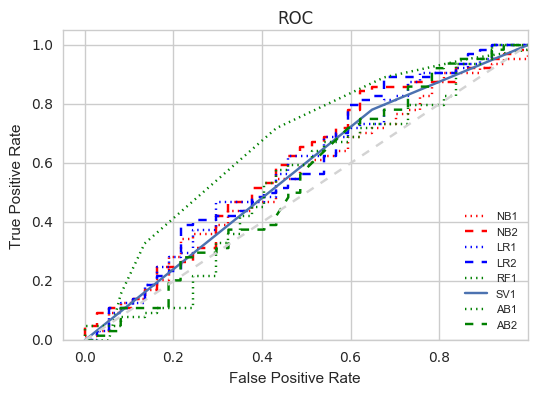

In [286]:
### Plot ROC curve for top model of each model type
plt.title('ROC');
plt.plot(NB1_fpr, NB1_tpr,color='r',label='NB1',linestyle='dotted');
plt.plot(NB2_fpr, NB2_tpr,color='r',label='NB2',linestyle='dashed');
plt.plot(LR1_fpr, LR1_tpr,color='b',label='LR1',linestyle='dotted');
plt.plot(LR2_fpr, LR2_tpr,color='b',label='LR2',linestyle='dashed');
plt.plot(RF1_fpr, RF1_tpr,color='g',label='RF1',linestyle='dotted');
plt.plot(SV1_fpr, SV1_tpr,label='SV1');
plt.plot(AB1_fpr, AB1_tpr,color='g',label='AB1',linestyle='dotted');
plt.plot(AB2_fpr, AB2_tpr,color='g',label='AB2',linestyle='dashed');
plt.legend(loc='lower right', prop={'size':8});
plt.plot([0,1],[0,1], color='lightgrey', linestyle='--');
plt.xlim([-0.05,1.0]);
plt.ylim([0.0,1.05]);
plt.ylabel('True Positive Rate');
plt.xlabel('False Positive Rate');

# 8. Create an ensemble from 7 above models (3 from allwords/part5, 4 from badwords/part7) and predict a final result with GradientBoosting

In [290]:
ensemble_predictions.head()

,NB_allWords,RF_allWords,AB_allWords,RF_badWords,AB1_badWords,AB2_badWords,SV_badWords
0,1.000000e+00,0.8,0.507252,0.7,0.509611,0.500654,0
1,1.612495e-36,1.0,0.330042,0.7,0.477767,0.504055,1
2,1.000000e+00,0.5,0.495975,0.7,0.598257,0.521868,1
3,1.000000e+00,0.9,0.507252,0.7,0.494104,0.514911,1
4,9.136140e-61,0.9,0.507252,0.6,0.503501,0.331522,0


In [292]:
#Train Test Split
X = np.asarray(ensemble_predictions)
y = np.asarray(data_df.score)
GBxTrain, GBxTest, GByTrain, GByTest = train_test_split(X,
                                              y,
                                              random_state=42,
                                               train_size=0.65)

In [293]:
def MSE_and_R2_CV_scores(estimators):
    "estimators is a list of instantiated estimator objects"
    "for which MSE and R2 scores are printed"
    i = 0
    for estimator in estimators:
        R2 = np.mean(cross_val_score(estimator,GBxTest,GByTest))
        MSE = -1*np.mean(cross_val_score(estimator,GBxTest,GByTest,scoring='neg_mean_squared_error'))
        out_string = estimator.__class__.__name__+' Test CV | MSE: '+str(MSE)+' | R2: '+str(R2)
        print(out_string)
        i = i+1

**GB Model 1.1** (adjusting learning rate)

GradientBoostingRegressor Test CV | MSE: 0.499983884749 | R2: -1.11515342533


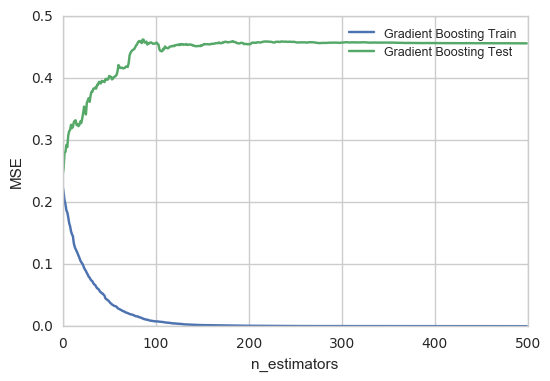

In [297]:
n__estimators = 500
learning__rate = 1.0
max__depth = 2.0
gb_search_1 = GradientBoostingRegressor(n_estimators=n__estimators,max_depth=max__depth,learning_rate=learning__rate,random_state=1)
#defaults for min_samples_leaf, max_features

gb_search_1.fit(GBxTrain,GByTrain) #fit
model_gb = [gb_search_1];MSE_and_R2_CV_scores(model_gb) #get scores

#plot
gb_train_MSE = np.zeros(n__estimators, dtype=np.float64)
gb_test_MSE = np.zeros(n__estimators, dtype=np.float64)
iterations = []
for i, y_pred in enumerate(gb_search_1.staged_predict(GBxTrain)):
    gb_train_MSE[i] = mean_squared_error(GByTrain,y_pred)
    iterations.append(i)
for i, y_pred in enumerate(gb_search_1.staged_predict(GBxTest)):
    gb_test_MSE[i] = mean_squared_error(GByTest,y_pred)
    
plt.plot(iterations, gb_train_MSE,label='Gradient Boosting Train');
plt.plot(iterations, gb_test_MSE,label='Gradient Boosting Test');
plt.ylabel('MSE')
plt.xlabel('n_estimators')
plt.legend(loc='upper right', prop={'size':9});
plt.show()

**GB Model 1.2**

GradientBoostingRegressor Test CV | MSE: 0.408036974396 | R2: -0.724479550877


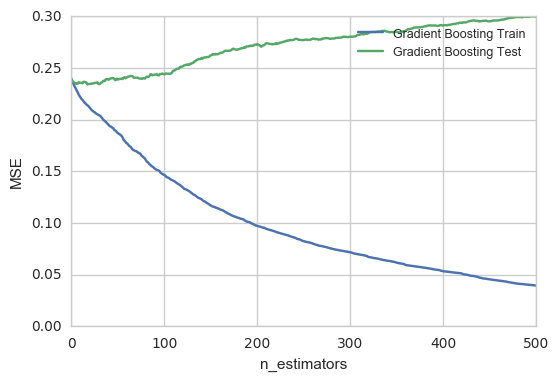

In [298]:
n__estimators = 500
learning__rate = 0.1
max__depth = 2.0
gb_search_1 = GradientBoostingRegressor(n_estimators=n__estimators,max_depth=max__depth,learning_rate=learning__rate,random_state=1)
#defaults for min_samples_leaf, max_features

gb_search_1.fit(GBxTrain,GByTrain) #fit
model_gb = [gb_search_1];MSE_and_R2_CV_scores(model_gb) #get scores

#plot
gb_train_MSE = np.zeros(n__estimators, dtype=np.float64)
gb_test_MSE = np.zeros(n__estimators, dtype=np.float64)
iterations = []
for i, y_pred in enumerate(gb_search_1.staged_predict(GBxTrain)):
    gb_train_MSE[i] = mean_squared_error(GByTrain,y_pred)
    iterations.append(i)
for i, y_pred in enumerate(gb_search_1.staged_predict(GBxTest)):
    gb_test_MSE[i] = mean_squared_error(GByTest,y_pred)
    
plt.plot(iterations, gb_train_MSE,label='Gradient Boosting Train');
plt.plot(iterations, gb_test_MSE,label='Gradient Boosting Test');
plt.ylabel('MSE')
plt.xlabel('n_estimators')
plt.legend(loc='upper right', prop={'size':9});
plt.show()

**GB Model 1.3**

GradientBoostingRegressor Test CV | MSE: 0.259933351131 | R2: -0.096377119537


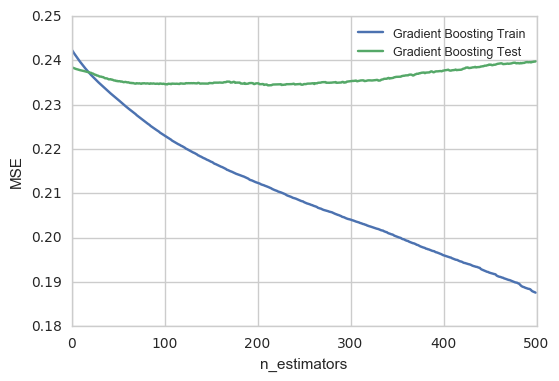

In [299]:
n__estimators = 500
learning__rate = 0.01
max__depth = 2.0
gb_search_1 = GradientBoostingRegressor(n_estimators=n__estimators,max_depth=max__depth,learning_rate=learning__rate,random_state=1)
#defaults for min_samples_leaf, max_features

gb_search_1.fit(GBxTrain,GByTrain) #fit
model_gb = [gb_search_1];MSE_and_R2_CV_scores(model_gb) #get scores

#plot
gb_train_MSE = np.zeros(n__estimators, dtype=np.float64)
gb_test_MSE = np.zeros(n__estimators, dtype=np.float64)
iterations = []
for i, y_pred in enumerate(gb_search_1.staged_predict(GBxTrain)):
    gb_train_MSE[i] = mean_squared_error(GByTrain,y_pred)
    iterations.append(i)
for i, y_pred in enumerate(gb_search_1.staged_predict(GBxTest)):
    gb_test_MSE[i] = mean_squared_error(GByTest,y_pred)
    
plt.plot(iterations, gb_train_MSE,label='Gradient Boosting Train');
plt.plot(iterations, gb_test_MSE,label='Gradient Boosting Test');
plt.ylabel('MSE')
plt.xlabel('n_estimators')
plt.legend(loc='upper right', prop={'size':9});
plt.show()

**GB Model 1.4**

GradientBoostingRegressor Test CV | MSE: 0.240989118003 | R2: -0.0186148935128


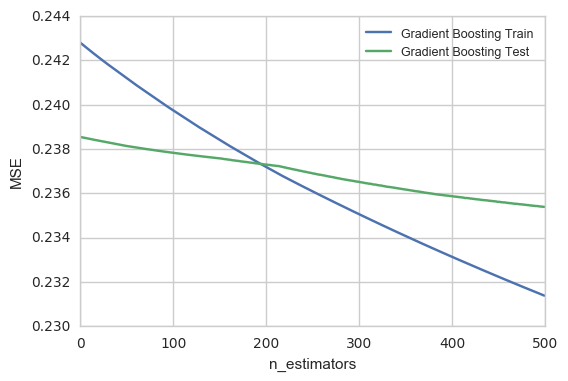

In [300]:
n__estimators = 500
learning__rate = 0.001
max__depth = 2.0
gb_search_1 = GradientBoostingRegressor(n_estimators=n__estimators,max_depth=max__depth,learning_rate=learning__rate,random_state=1)
#defaults for min_samples_leaf, max_features

gb_search_1.fit(GBxTrain,GByTrain) #fit
model_gb = [gb_search_1];MSE_and_R2_CV_scores(model_gb) #get scores

#plot
gb_train_MSE = np.zeros(n__estimators, dtype=np.float64)
gb_test_MSE = np.zeros(n__estimators, dtype=np.float64)
iterations = []
for i, y_pred in enumerate(gb_search_1.staged_predict(GBxTrain)):
    gb_train_MSE[i] = mean_squared_error(GByTrain,y_pred)
    iterations.append(i)
for i, y_pred in enumerate(gb_search_1.staged_predict(GBxTest)):
    gb_test_MSE[i] = mean_squared_error(GByTest,y_pred)
    
plt.plot(iterations, gb_train_MSE,label='Gradient Boosting Train');
plt.plot(iterations, gb_test_MSE,label='Gradient Boosting Test');
plt.ylabel('MSE')
plt.xlabel('n_estimators')
plt.legend(loc='upper right', prop={'size':9});
plt.show()

**GB Model 1.5**

GradientBoostingRegressor Test CV | MSE: 0.241520869047 | R2: -0.0205166489685


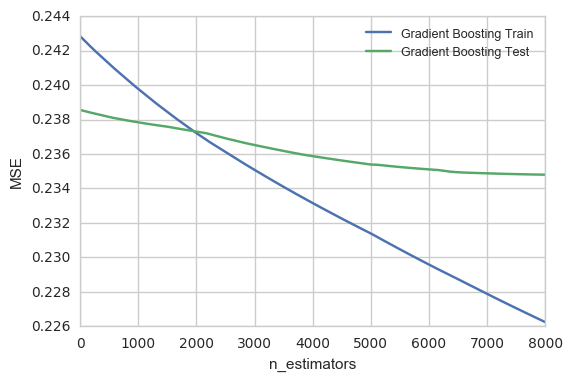

In [303]:
n__estimators = 8000
learning__rate = 0.0001
max__depth = 2.0
gb_search_1 = GradientBoostingRegressor(n_estimators=n__estimators,max_depth=max__depth,learning_rate=learning__rate,random_state=1)
#defaults for min_samples_leaf, max_features

gb_search_1.fit(GBxTrain,GByTrain) #fit
model_gb = [gb_search_1];MSE_and_R2_CV_scores(model_gb) #get scores

#plot
gb_train_MSE = np.zeros(n__estimators, dtype=np.float64)
gb_test_MSE = np.zeros(n__estimators, dtype=np.float64)
iterations = []
for i, y_pred in enumerate(gb_search_1.staged_predict(GBxTrain)):
    gb_train_MSE[i] = mean_squared_error(GByTrain,y_pred)
    iterations.append(i)
for i, y_pred in enumerate(gb_search_1.staged_predict(GBxTest)):
    gb_test_MSE[i] = mean_squared_error(GByTest,y_pred)
    
plt.plot(iterations, gb_train_MSE,label='Gradient Boosting Train');
plt.plot(iterations, gb_test_MSE,label='Gradient Boosting Test');
plt.ylabel('MSE')
plt.xlabel('n_estimators')
plt.legend(loc='upper right', prop={'size':9});
plt.show()

**GB Model 2.1** (dialing tree number)

GradientBoostingRegressor Test CV | MSE: 0.251060538743 | R2: -0.0607317316681


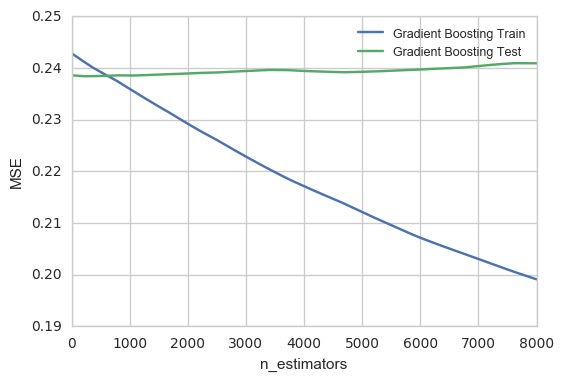

In [304]:
n__estimators = 8000
learning__rate = 0.0001
max__depth = 4
gb_search_1 = GradientBoostingRegressor(n_estimators=n__estimators,max_depth=max__depth,learning_rate=learning__rate,random_state=1)
#defaults for min_samples_leaf, max_features

gb_search_1.fit(GBxTrain,GByTrain) #fit
model_gb = [gb_search_1];MSE_and_R2_CV_scores(model_gb) #get scores

#plot
gb_train_MSE = np.zeros(n__estimators, dtype=np.float64)
gb_test_MSE = np.zeros(n__estimators, dtype=np.float64)
iterations = []
for i, y_pred in enumerate(gb_search_1.staged_predict(GBxTrain)):
    gb_train_MSE[i] = mean_squared_error(GByTrain,y_pred)
    iterations.append(i)
for i, y_pred in enumerate(gb_search_1.staged_predict(GBxTest)):
    gb_test_MSE[i] = mean_squared_error(GByTest,y_pred)
    
plt.plot(iterations, gb_train_MSE,label='Gradient Boosting Train');
plt.plot(iterations, gb_test_MSE,label='Gradient Boosting Test');
plt.ylabel('MSE')
plt.xlabel('n_estimators')
plt.legend(loc='upper right', prop={'size':9});
plt.show()

**GB Model 2.2**

GradientBoostingRegressor Test CV | MSE: 0.241256089471 | R2: -0.019864728801


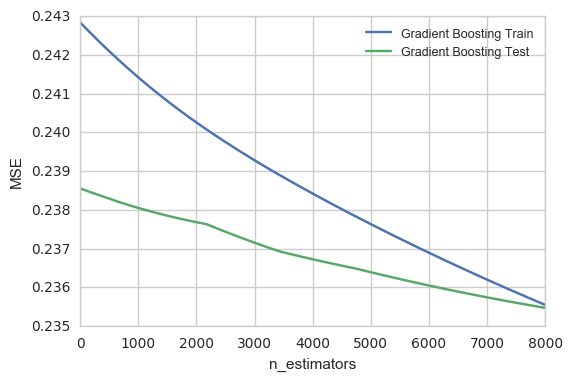

In [305]:
n__estimators = 8000
learning__rate = 0.0001
max__depth = 1
gb_search_1 = GradientBoostingRegressor(n_estimators=n__estimators,max_depth=max__depth,learning_rate=learning__rate,random_state=1)
#defaults for min_samples_leaf, max_features

gb_search_1.fit(GBxTrain,GByTrain) #fit
model_gb = [gb_search_1];MSE_and_R2_CV_scores(model_gb) #get scores

#plot
gb_train_MSE = np.zeros(n__estimators, dtype=np.float64)
gb_test_MSE = np.zeros(n__estimators, dtype=np.float64)
iterations = []
for i, y_pred in enumerate(gb_search_1.staged_predict(GBxTrain)):
    gb_train_MSE[i] = mean_squared_error(GByTrain,y_pred)
    iterations.append(i)
for i, y_pred in enumerate(gb_search_1.staged_predict(GBxTest)):
    gb_test_MSE[i] = mean_squared_error(GByTest,y_pred)
    
plt.plot(iterations, gb_train_MSE,label='Gradient Boosting Train');
plt.plot(iterations, gb_test_MSE,label='Gradient Boosting Test');
plt.ylabel('MSE')
plt.xlabel('n_estimators')
plt.legend(loc='upper right', prop={'size':9});
plt.show()

**GB Model 2.2b--taking stumps out to more estimators**

GradientBoostingRegressor Test CV | MSE: 0.243494259453 | R2: -0.0288206417174


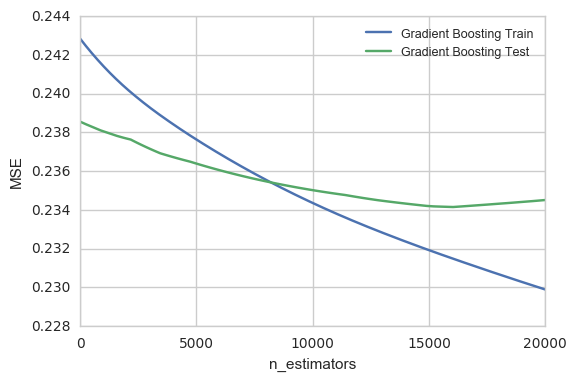

In [307]:
n__estimators = 20000
learning__rate = 0.0001
max__depth = 1
gb_search_1 = GradientBoostingRegressor(n_estimators=n__estimators,max_depth=max__depth,learning_rate=learning__rate,random_state=1)
#defaults for min_samples_leaf, max_features

gb_search_1.fit(GBxTrain,GByTrain) #fit
model_gb = [gb_search_1];MSE_and_R2_CV_scores(model_gb) #get scores

#plot
gb_train_MSE = np.zeros(n__estimators, dtype=np.float64)
gb_test_MSE = np.zeros(n__estimators, dtype=np.float64)
iterations = []
for i, y_pred in enumerate(gb_search_1.staged_predict(GBxTrain)):
    gb_train_MSE[i] = mean_squared_error(GByTrain,y_pred)
    iterations.append(i)
for i, y_pred in enumerate(gb_search_1.staged_predict(GBxTest)):
    gb_test_MSE[i] = mean_squared_error(GByTest,y_pred)
    
plt.plot(iterations, gb_train_MSE,label='Gradient Boosting Train');
plt.plot(iterations, gb_test_MSE,label='Gradient Boosting Test');
plt.ylabel('MSE')
plt.xlabel('n_estimators')
plt.legend(loc='upper right', prop={'size':9});
plt.show()

**Final GB Model: 16000 stumps**

In [310]:
n__estimators = 16000
learning__rate = 0.0001
max__depth = 1
GBC_model = GradientBoostingRegressor(n_estimators=n__estimators,max_depth=max__depth,learning_rate=learning__rate,random_state=1)
GBC_model.fit(GBxTrain,GByTrain)
predictions = GBC_model.predict(GBxTest)

In [315]:
predictions[:10]

array([ 0.57151861,  0.67202099,  0.57151861,  0.57064885,  0.57064885,
        0.67115123,  0.67202099,  0.54257862,  0.57064885,  0.52662603])

In [313]:
GB_fpr, GB_tpr, thresholds = roc_curve(GByTest,predictions)
CM_ = np.asarray([[0,1],[1,0]]).dot(confusion_matrix(predictions_,yTest)).dot(np.asarray([[0,1],[1,0]])).T
CM = pd.DataFrame(CM_,columns=['Predicted +','Predicted -'])
CM.index = ['Actual +','Actual -']

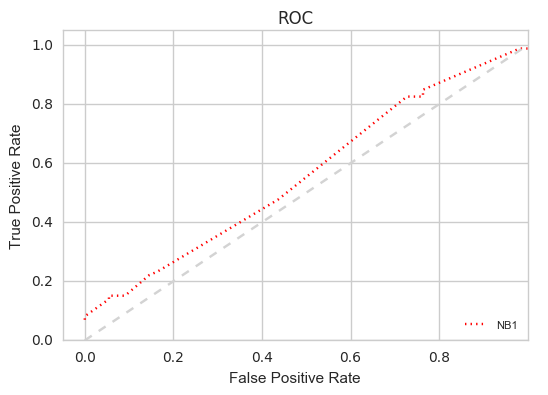

In [316]:
### Plot ROC curve for GB
plt.title('ROC');
plt.plot(GB_fpr, GB_tpr,color='r',label='NB1',linestyle='dotted');
plt.legend(loc='lower right', prop={'size':8});
plt.plot([0,1],[0,1], color='lightgrey', linestyle='--');
plt.xlim([-0.05,1.0]);
plt.ylim([0.0,1.05]);
plt.ylabel('True Positive Rate');
plt.xlabel('False Positive Rate');

In [330]:
threshold = 0.5
GB_final_score = [1 if x>threshold else 0 for x in predictions]

accuracy = accuracy_score(GB_final_score,GByTest)
precision = precision_score(GB_final_score,GByTest)
recall = recall_score(GB_final_score,GByTest)
f1 = f1_score(GB_final_score,GByTest)
print('accuracy: '+str(accuracy)+' | precision: '+str(precision))
print('recall: '+str(recall)+' | f1: '+str(f1))

accuracy: 0.609929078014 | precision: 0.976744186047
recall: 0.613138686131 | f1: 0.7533632287


^Just barely beats null model

### As a final cell, I'll put up the metrics from one of the best performing models:
### an AdaBooster useing TFIDF from badwords, give a ~66% predition rate

In [360]:
#doc_term_matrices[11] is a TFIDF of tri-grams from the badwords corpus
top_model_AB1 = AdaBoostClassifier()
top_model_AB1.fit(doc_term_matrices[11]['train'],yTrain)
predictions__ = list(top_model_AB1.predict_proba(doc_term_matrices[11]['test'])[:,1])

threshold = 0.4
predictions_ = [1 if x>threshold else 0 for x in predictions__]

accuracy = accuracy_score(predictions_,yTest)
precision = precision_score(predictions_,yTest)
recall = recall_score(predictions_,yTest)
f1 = f1_score(predictions_,yTest)
print('accuracy: '+str(accuracy)+' | precision: '+str(precision))
print('recall: '+str(recall)+' | f1: '+str(f1))

accuracy: 0.663366336634 | precision: 1.0
recall: 0.65306122449 | f1: 0.79012345679
